In [2]:
#########################################################################
#                                                                       #
# Import Kepler Data and Pick out points corresponding to 124 < t < 125 #
#                                                                       #
#########################################################################

import math
import numpy as np
import kplr

# Find the target KOI.
client = kplr.API()
koi = client.koi(97.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=False)

# Open the first dataset and read it
f = lcs[0].open()

hdu_data = f[1].data
time = hdu_data["time"]

index = np.where((time>124)&(time<125))
hdu = hdu_data[index]


flux_eclipse = hdu["sap_flux"]
time_eclipse = hdu["time"]
err_eclipse = hdu["sap_flux_err"]

f.close()

In [3]:
#########################################################################
#                                                                       #
# Perform two sigma exclusion 5 times to remove points 2 sigma away     #
# from the mean and calculate unobscured flux. Should get 33 entries    #
#                                                                       #
#########################################################################

non_transit = flux_eclipse

for i in range(5):
    mean = np.mean(non_transit)
    sigma = np.std(non_transit)

    twosigtest = abs(non_transit - mean)/(sigma)
    new_indices = np.where((twosigtest<2))
    non_transit = non_transit[new_indices]

unobscured_mean = np.mean(non_transit)

raw_Flux_Ratios = np.zeros(len(flux_eclipse))
for i in range(len(flux_eclipse)):
    raw_Flux_Ratios [i] = flux_eclipse[i] / unobscured_mean

print(len(non_transit))

33


In [4]:
########################################################################
#                                                                      #
#      Perform model calculations using scipy integration package      #
#                                                                      #
########################################################################

from scipy.integrate import quad

#set parameters
p = 0.0775
tau = 0.1
t_0 = 124.51

#convert times in UTC to z (normalized separation of the centers)
#t_0 = time of max flux eclipse
#tau - related to duration of eclipse
z_Kepler = np.zeros(len(flux_eclipse))
for i in range(len(flux_eclipse)):
    z_Kepler[i] = (time_eclipse[i] - t_0) / tau

#define Delta function, specific intensity, numerator and denominator of flux ratio function
def Delta_Function(r,p,z): 
    r_squared = math.pow(r,2)
    z_squared = math.pow(z,2)
    p_squared = math.pow(p,2)
    if r >= z+p or r <= z-p:
        return 0 
    elif r + z <= p: 
        return 1
    else:
        return (math.pow(math.pi,-1)) * math.acos((z_squared - p_squared + r_squared) / (2*z*r))

def I(r):
    '''A Limb-darkening function'''
    mu = (1 - (r**2))**(0.5)
    return 1 - (1 - (mu**(0.5)))

def func1(r, p, z):
    return I(r) * (1 - Delta_Function(r,p,abs(z))) * 2 * r

def func2(r):
    return I(r) * 2 * r

#find model flux values
Model_Fluxes = np.zeros(len(flux_eclipse))

for i in range(len(flux_eclipse)):
    z_i = z_Kepler[i]
    Model_Fluxes[i] = quad(func1, 0, 1, args = (p, z_i))[0]/(quad(func2, 0, 1)[0])

print(Model_Fluxes)

[ 1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.
  0.99490342  0.99357217  0.99295949  0.99263701  0.99250547  0.99253549
  0.99273335  0.99314721  0.99393552  0.99667521  1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.        ]


In [5]:
########################################################################
#                                                                      #
#      Compute chi squared                                             #
#                                                                      #
########################################################################

chi_squared = 0

for i in range(len(flux_eclipse)):
    chi_squared += math.pow((raw_Flux_Ratios[i] - Model_Fluxes[i])/(err_eclipse[i]/unobscured_mean),2)

PROBLEM 2 : The model seems to be a pretty good fit just "by eye". However, it turns out that because the uncertainties of the measurements are so small, the fit is actually terrible as indicated by the infinitesimally small p-value. Varying the parameters will allow us to find better fits to this curve, however, given the very small error/uncertainty bars in the data, I am skeptical as to whether the p-value will improve by much.

<IPython.core.display.Javascript object>


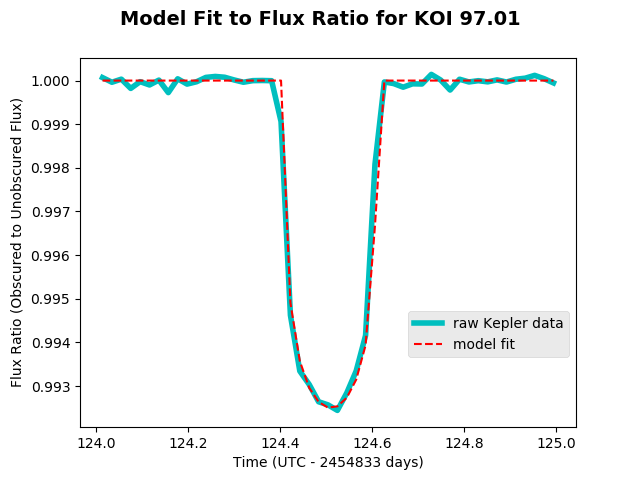

chi squared: 465.1986924205623
p-value: 1.098869030223193e-70


In [6]:
########################################################################
#                                                                      #
#      Compute p-value, plot data overlayed with model                 #
#                                                                      #
########################################################################
import matplotlib.pyplot as plt
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(time_eclipse, raw_Flux_Ratios, color = 'c', linewidth = 4.0, label = 'raw Kepler data')
plt.plot(time_eclipse, Model_Fluxes, 'r--', label = 'model fit')
plt.style.use('ggplot')

fig.suptitle('Model Fit to Flux Ratio for KOI 97.01', fontsize=14, fontweight='bold')
ax.set_xlabel('Time (UTC - 2454833 days)')
ax.set_ylabel('Flux Ratio (Obscured to Unobscured Flux)')
plt.legend(bbox_to_anchor=(1.07, 0.427), loc=1, borderaxespad=3)


nu = len(flux_eclipse) - 3
a = nu / 2
x = chi_squared / 2

def Inc_Gamma_Integrand(t,a): 
    return(math.exp(-t) * math.pow(t,a-1))

def p_value(a, x):
    return(quad(Inc_Gamma_Integrand, x, math.inf, args=(a))[0] / quad(Inc_Gamma_Integrand, 0, math.inf, args=(a))[0])

p = p_value(a,x)
print('chi squared: ' + str(chi_squared))
print('p-value: ' + str(p))
